In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
#import pickle
#from scipy.spatial import cKDTree
#from SCTransform import SCTransform
from scipy import sparse
import anndata

#from nico import Annotations as sann
import Annotations as sann


import warnings
import time
warnings.filterwarnings('ignore')
#export PYTHONWARNINGS='ignore:Multiprocessing-backed parallel loops:UserWarning'
os.environ["PYTHONWARNINGS"] = "ignore::UserWarning"



### Usage introduction 
Please download the sample data from the git repository nico_tutorial and keep all the files and folders in
the same directory to complete the tutorial. 

inputRef  (single-cell RNA-sequencing data) 
inputQuery (single-cell resolution spatial transcriptomics data)
NiCoLRdb.txt (Ligand-receptor database file) 

The following notebook normalizes the count data and computes the initial Leiden clustering on the spatial transcriptomics 
data to perform the cell type annotation using NiCo:
Start_Data_preparation_for_niche_analysis.ipynb

Once all the steps of the data preparation notebook are finalized, run the core notebook to perform the full NiCo analysis: 
Perform_spatial_analysis.ipynb


In [2]:
# This function find the common gene index between two data.  
def find_index(sp_genename,sc_genename):
    index_sc=[]
    index_sp=[]
    d={}
    for j in range(len(sc_genename)):
        name=sc_genename[j]
        d[name]=j

    for i in range(len(sp_genename)):
        name=sp_genename[i]
        try:
            d[name]
            flag=1
        except KeyError:
            flag=0
        if flag==1:
            index_sc.append(d[name])
            index_sp.append(i)
    return index_sp,index_sc


In [3]:
# This is input data path for the scRNA-seq and spatial data 
# If the data is not in h5ad or csv format then please adjust following the standard scanpy routine. 

scdatapath='./inputRef/'
spdatapath='./inputQuery/'

ad_spatial_ori=sc.read_10x_h5(spdatapath+'cell_feature_matrix.h5')
#ad_seq_ori=sc.read_h5ad(scdatapath+'input_ref.h5ad') 

# This is the coordinate file of the cell centroids from the spatial transcriptomics experiment.  
coordinate = pd.read_csv(spdatapath+'cells.csv')
#coordinate=coordinate.to_numpy()


In [4]:
coordinate=coordinate.to_numpy()[:,0:3]

In [5]:
# make sure that the order of cells in the count matrix and in the cell location 
#matrix are identical (command should return TRUE); otherwise correct the order

np.array_equal(coordinate[:,0],ad_spatial_ori.obs_names)

True

In [6]:
ad_spatial_ori.obsm['spatial']=coordinate[:,1:].astype(float)

## The scRNAseq data is in 3 column sparse format so need a custom way to load it  

In [7]:
df=pd.read_csv(scdatapath+'counts.csv',header=1,sep=' ')
print(df.columns)
print(df.shape)
data=df.to_numpy()

Index(['32285', '84961', '215051781'], dtype='object')
(215051781, 3)


In [8]:
# create an initialization matrix with integer data type 
mat=np.zeros((int(df.columns[0]),int(df.columns[1])),dtype=int)

In [9]:
#Because python index start from 0 and %%MatrixMarket matrix format looks like start
# from 1 so subtract -1 from everyone 

mat[data[:,0]-1,data[:,1]-1]=data[:,2]

In [10]:
#mat=mat/mat.sum(axis=0)

In [11]:
# load mat object into anndata object 
adata = anndata.AnnData(  sparse.csr_matrix(mat))
adata = adata.transpose() 

In [12]:
adata

AnnData object with n_obs × n_vars = 84961 × 32285

In [13]:
#load other files 

df=pd.read_csv(scdatapath+'genes.csv',header=0,sep=',')
gene_names=df.to_numpy()[:,1]
print(gene_names[0:3])

df=pd.read_csv(scdatapath+'barcodes.csv',header=0,sep=',')
cell_names=df.to_numpy()[:,1]
print(cell_names[0:3])

# df=pd.read_csv(scdatapath+'anno_simple.csv')
# updated annotation where not-annotated cells are combined into CM
df=pd.read_csv(scdatapath+'anno_simple_new.csv')
df['cluster_ann_simplify'][df['cluster_ann_simplify'].isin(['Macro_MHCII_Cx3cr1','Macro_Trem2_Gpnmb', 'Macrophages_Ly6C', 'Macrophages_Timd4'])]='Macrophages'
#df['cluster_ann_simplify'][df['cluster_ann_simplify'].isin(['Macro_MHCII_Cx3cr1','Macro_Trem2_Gpnmb'])]='Macro_Trem2_Cx3cr1'
df['cluster_ann_simplify'][df['cluster_ann_simplify'].isin(['Pericytes', 'vPericyte_quiescent'])]='Pericytes'
df['cluster_ann_simplify'][df['cluster_ann_simplify'].isin(['vEC_Immune', 'vEC_metabolic','EC_capillary'])]='EC_capillary'
simple_annot=df.to_numpy()[:,2]



print(simple_annot[0:3])
timepoints=df[['cells_timepoints']].to_numpy()

# df=pd.read_csv(scdatapath+'anno_detail.csv')
# updated annotation where not-annotated cells are combined into CM
df=pd.read_csv(scdatapath+'anno_detail_new.csv')

df['cluster_ann_all'][df['cluster_ann_all'].isin(['T_CD4_effector', 'T_CD4_naive'])]='T_CD4'
df['cluster_ann_all'][df['cluster_ann_all'].isin(['T_CD8_effector', 'T_CD8_naive'])]='T_CD8'

df['cluster_ann_all'][df['cluster_ann_all'].isin(['FB_Cxcl14','FB_quiescent'])]='FB_quiescent'
df['cluster_ann_all'][df['cluster_ann_all'].isin(['FB_Ccl2', 'FBmyo'])]='FBmyo_main'
df['cluster_ann_all'][df['cluster_ann_all'].isin(['Fbmyo_Dkk2'])]='FB_Postn_Thbs4'

detail_annot=df.to_numpy()[:,2]
print(detail_annot[0:3])

#df=pd.read_csv(scdatapath+'umap.csv')
df=pd.read_csv(scdatapath+'tsne.csv')
umap=df.to_numpy()[:,[1,2]]
print(umap[0:3])

df=pd.read_csv(scdatapath+'tsne.csv')
tsne=df.to_numpy()[:,[1,2]]
print(tsne[0:3])



['Xkr4' 'Gm1992' 'Gm19938']
['NM_Ad_LA_D01_AAACCCAAGATGGCAC-1' 'NM_Ad_LA_D01_AAACCCAAGCGTATAA-1'
 'NM_Ad_LA_D01_AAACCCAAGGGTAGCT-1']
['Neutrophil' 'Fibroblasts' 'Macrophages']
['Neutrophil_2' 'FBmyo_main' 'mo_Macro_Spp1']
[[19.0472089281391 -16.8381218983597]
 [-8.58059027886247 -12.8891057153142]
 [-0.366651303592678 3.34849807808145]]
[[19.0472089281391 -16.8381218983597]
 [-8.58059027886247 -12.8891057153142]
 [-0.366651303592678 3.34849807808145]]


In [14]:
timepoints[:,0]

array(['D01', 'D01', 'D01', ..., 'Sham', 'Sham', 'Sham'], dtype=object)

In [15]:
# add into anndata object 

adata.obs_names=cell_names
adata.var_names= gene_names 
adata.obs['simple_annot']=simple_annot 
adata.obs['detail_annot']=detail_annot 
adata.obsm['X_umap']= umap.astype(float) 
adata.obsm['X_tsne'] = tsne.astype(float) 
adata.obs['timepoints']=timepoints[:,0]

In [16]:
np.unique(adata.obs['detail_annot'])

array(['B_cells', 'CM_Angiogenic', 'CM_Btk+', 'CM_Dedifferentiating',
       'CM_Homeostatic1', 'CM_Homeostatic2', 'CM_Hypertrophic',
       'CM_Prehypertrophic', 'CM_Slit2+', 'DC_CCR7', 'DC_con1',
       'DC_con2_Ifitm1', 'DC_con2b/moDC', 'DC_plasmacytoid',
       'Erythrocyte', 'FB_Duox1', 'FB_Fgl2', 'FB_Postn_Thbs4', 'FB_Saa3',
       'FB_WntX', 'FB_quiescent', 'FB_transition_Cd9',
       'FB_transition_Il1rapl1', 'FBmyo_IFN', 'FBmyo_main', 'Fbmyo_Hp',
       'Fbmyo_cycling', 'Fibrocytes', 'ILC2', 'ILC2_IL5', 'MAIT',
       'MAIT_IL17', 'Macro_Cxcl13', 'Macro_MHCII_Cx3cr1', 'Macro_Retnla',
       'Macro_Timd4_Lyve1', 'Macro_Trem2_Gpnmb', 'Mast_cells', 'NK_Gzma',
       'NK_Klra5', 'NK_T', 'Neutrophil_1', 'Neutrophil_2',
       'Schwann_Galectin', 'Schwann_IFN', 'Schwann_metabolic',
       'Schwann_quiescent', 'T_CD4', 'T_CD8', 'T_IFNg_naive', 'T_Isg15',
       'T_Macro', 'T_gd', 'Treg', 'mo_Macro_Il10_Fn1',
       'mo_Macro_Ly6C_Isg15_Cxcl3', 'mo_Macro_Spp1', 'vEC_Areg_Dkk2_Wnt',
  

In [17]:
adata

AnnData object with n_obs × n_vars = 84961 × 32285
    obs: 'simple_annot', 'detail_annot', 'timepoints'
    obsm: 'X_umap', 'X_tsne'

In [18]:
#np.unique(adata.obs['detail_annot'])

In [19]:
np.unique(adata.obs['timepoints'])


array(['D01', 'D03', 'D07', 'D28', 'D56', 'Sham'], dtype=object)

In [20]:
adata1= adata[adata.obs['timepoints'].isin(['D01','D03','D07'])]
np.unique(adata1.obs['timepoints'])
adata = adata1

In [21]:

#df =olddf[index[0]]

#fcells=cell_names
#fcells=df["Unnamed: 0"][df["cells_timepoints"].isin(['D07'])].to_list()  # works for Fib proliferation
#fcells=df["Unnamed: 0"][df["cells_timepoints"].isin(['D01','D03','D07', 'D28', 'D56'])].to_list() # works for Ded CM ILC niche
#fcells=df["Unnamed: 0"][df["cells_timepoints"].isin(['D07','D03'])].to_list() # works for Fib proliferation

In [22]:
#fcells=df["Unnamed: 0"][df["cells_timepoints"].isin(['D01','D03','D07', 'D28', 'D56'])].to_list() # works for Ded CM ILC niche

In [23]:
#adata=adata[fcells,]

In [24]:
# The copy into default tutorial now 
ad_seq_ori = adata.copy()

### If spatial h5ad object is already available 
If the user already has spatial data in h5ad format with coordinate information tagged as spatial (.obsm['spatial']), they can skip the above command and directly load the spatial data as follows.

ad_spatial_ori=sc.read_h5ad(spdatapath+'input_query_spatial_data.h5ad')

In [25]:
# data size of the variables 
print(ad_spatial_ori)
print(ad_seq_ori)
print(coordinate.shape)

AnnData object with n_obs × n_vars = 27737 × 475
    var: 'gene_ids', 'feature_types', 'genome'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 54212 × 32285
    obs: 'simple_annot', 'detail_annot', 'timepoints'
    obsm: 'X_umap', 'X_tsne'
(27737, 3)


In [26]:
# Filter the cells and genes 
sc.pp.filter_cells(ad_spatial_ori, min_counts=5)
sc.pp.filter_cells(ad_seq_ori, min_counts=5)

sc.pp.filter_genes(ad_spatial_ori, min_cells=1)
sc.pp.filter_genes(ad_seq_ori, min_cells=1)

print(ad_spatial_ori)
print(ad_seq_ori)

AnnData object with n_obs × n_vars = 27452 × 475
    obs: 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 54212 × 27182
    obs: 'simple_annot', 'detail_annot', 'timepoints', 'n_counts'
    var: 'n_cells'
    obsm: 'X_umap', 'X_tsne'


### Original scRNAseq data 
Copy the scRNA-seq data into new variables as well as into the raw layer 
The Original_count count matrix will be used to derive the UMAP for the scRNA-seq data. 
The raw layer count matrix will be used to find the Spearman and Cosine similarity of genes with the latent factors. 

In [27]:
Original_counts=ad_seq_ori.copy()
Original_counts.raw=Original_counts.copy()

In [28]:
#Original_counts.obs_names=fcells
#Original_counts=Original_counts[fcells]

In [29]:
# Standard scanpy analysis 
# This step not required now because it already has all the objects 
'''
sc.pp.normalize_total(Original_counts)
sc.pp.log1p(Original_counts)

sc.tl.pca(Original_counts)
sc.pp.neighbors(Original_counts)
sc.tl.umap(Original_counts)
sc.pl.umap(Original_counts)
'''

'\nsc.pp.normalize_total(Original_counts)\nsc.pp.log1p(Original_counts)\n\nsc.tl.pca(Original_counts)\nsc.pp.neighbors(Original_counts)\nsc.tl.umap(Original_counts)\nsc.pl.umap(Original_counts)\n'

In [30]:
# save the data 
Original_counts.write_h5ad(scdatapath+'Original_counts.h5ad')

### Find shared genes 
Now find the shared genes between two modalities and subset the matrix to retain only common genes. 

In [31]:
sp_genename=ad_spatial_ori.var_names.to_numpy()
sc_genename=ad_seq_ori.var_names.to_numpy()

index_sp,index_sc=find_index(sp_genename,sc_genename)
ad_seq_common=ad_seq_ori#[:,index_sc].copy()
ad_spatial_common=ad_spatial_ori#[:,index_sp].copy()

#ad_seq_common=ad_seq_ori[:,index_sc].copy()
#ad_spatial_common=ad_spatial_ori[:,index_sp].copy()

print(len(sp_genename[index_sp]))
print(len(sc_genename[index_sc]))



468
468


### Perform scTransform like normalization with two different alternative stratgies

In [32]:
# Alternative 1 
# The sctransform normalization function used from scanpy 


ad_seq_common.raw=ad_seq_common.copy()
ad_spatial_common.raw=ad_spatial_common.copy()
# perform scTranform normalization common gene space for spatial data and scRNAseq data  
sc.experimental.pp.normalize_pearson_residuals(ad_seq_common,inplace=True) #ad_seq_common.X[ad_seq_common.X<0]=0
ad_seq_common=ad_seq_common[:,index_sc]
ad_seq_common.write_h5ad(scdatapath+'sct_singleCell.h5ad')

sc.experimental.pp.normalize_pearson_residuals(ad_spatial_common,inplace=True) #ad_spatial_common.X[ad_spatial_common.X<0]=0
#print(ad_spatial_common.X.toarray()
ad_spatial_common=ad_spatial_common[:,index_sp]

In [33]:
# Alternative 2
# The normalization function used from external functions 
# In the paper this functions was used

'''
temp_spatial=ad_spatial_common.copy()
temp_seq=ad_seq_common.copy()

sct_ad_sp = sann.SCTransform(ad_spatial_common,min_cells=1,gmean_eps=1,n_genes=500,n_cells=None, #use all cells
                        bin_size=500,bw_adjust=3,inplace=False)

sct_ad_sc = sann.SCTransform(ad_seq_common,min_cells=1,gmean_eps=1,n_genes=500,n_cells=None, #use all cells
		                bin_size=500,bw_adjust=3,inplace=False)

ad_spatial_common=sct_ad_sp.copy()
ad_seq_common=sct_ad_sc.copy()

ad_spatial_common.raw=temp_spatial.copy()
ad_seq_common.raw=temp_seq.copy()
ad_spatial_common.obsm['spatial']= temp_spatial.obsm['spatial']

ad_seq_common.write_h5ad(scdatapath+'sct_singleCell.h5ad')
'''

"\ntemp_spatial=ad_spatial_common.copy()\ntemp_seq=ad_seq_common.copy()\n\nsct_ad_sp = sann.SCTransform(ad_spatial_common,min_cells=1,gmean_eps=1,n_genes=500,n_cells=None, #use all cells\n                        bin_size=500,bw_adjust=3,inplace=False)\n\nsct_ad_sc = sann.SCTransform(ad_seq_common,min_cells=1,gmean_eps=1,n_genes=500,n_cells=None, #use all cells\n\t\t                bin_size=500,bw_adjust=3,inplace=False)\n\nad_spatial_common=sct_ad_sp.copy()\nad_seq_common=sct_ad_sc.copy()\n\nad_spatial_common.raw=temp_spatial.copy()\nad_seq_common.raw=temp_seq.copy()\nad_spatial_common.obsm['spatial']= temp_spatial.obsm['spatial']\n\nad_seq_common.write_h5ad(scdatapath+'sct_singleCell.h5ad')\n"

# Perform Leiden clustering on spatial transcriptomics data to guide the NiCo annotations 

In [34]:
# standard scanpy analysis 
sc.pp.pca(ad_spatial_common)
sc.pp.neighbors(ad_spatial_common,n_pcs=30)
sc.tl.umap(ad_spatial_common)

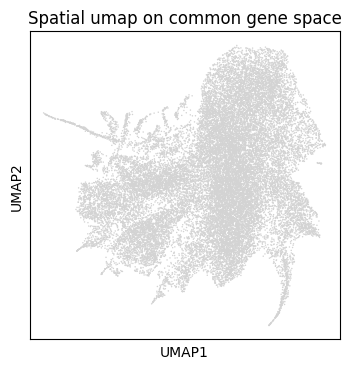

In [35]:
# visualize umap 
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(ad_spatial_common, title=["Spatial umap on common gene space"],wspace=0.4,show=True)

### Guiding Leiden cluster resolutions
Peform Leiden clustering for several resolution parameters. 
If it takes a long time to compute, then you can limit the number of parameters. 

Any of the resolution parameters  here can be used as an input parameter (guiding_spatial_cluster_resolution_tag) in the NiCo pipeline

In [36]:
sc.tl.leiden(ad_spatial_common, resolution=0.3,key_added="leiden0.3")
sc.tl.leiden(ad_spatial_common, resolution=0.4,key_added="leiden0.4")
sc.tl.leiden(ad_spatial_common, resolution=0.5,key_added="leiden0.5")
sc.tl.leiden(ad_spatial_common, resolution=0.2,key_added="leiden0.2")
sc.tl.leiden(ad_spatial_common, resolution=0.1,key_added="leiden0.1")
#sc.tl.leiden(sct_ad_sp, resolution=0.8,key_added="leiden0.8")

In [37]:
sc.tl.leiden(ad_spatial_common, resolution=0.6,key_added="leiden0.6")
sc.tl.leiden(ad_spatial_common, resolution=0.7,key_added="leiden0.7")
sc.tl.leiden(ad_spatial_common, resolution=0.8,key_added="leiden0.8")
sc.tl.leiden(ad_spatial_common, resolution=1.0,key_added="leiden1.0")

In [38]:
sc.tl.leiden(ad_spatial_common, resolution=0.9,key_added="leiden0.9")

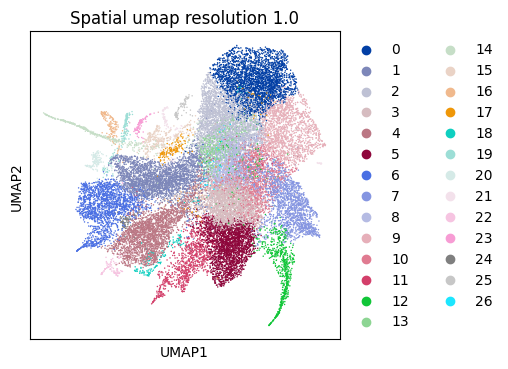

In [39]:
# Visualize your initial spatial clustering in the umap 
# A good resolution parameter should yield clusters corresponding to major cell types.  

sc.pl.umap(ad_spatial_common, color=["leiden1.0"], title=["Spatial umap resolution 1.0"],wspace=0.4,
           show=True, save='_spatial_leiden_louvain.png')

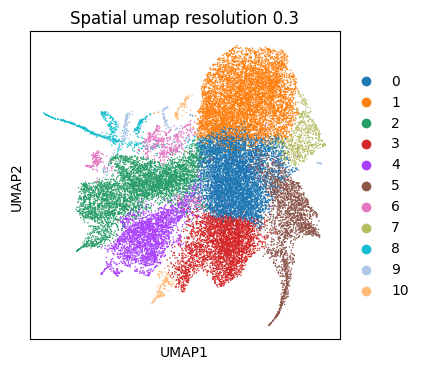

In [40]:
sc.pl.umap(ad_spatial_common, color=["leiden0.3"], title=["Spatial umap resolution 0.3"],wspace=0.4,
           show=True, save='_spatial_leiden_louvain.png')

In [41]:
ad_spatial_common

AnnData object with n_obs × n_vars = 27452 × 468
    obs: 'n_counts', 'leiden0.3', 'leiden0.4', 'leiden0.5', 'leiden0.2', 'leiden0.1', 'leiden0.6', 'leiden0.7', 'leiden0.8', 'leiden1.0', 'leiden0.9'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'pearson_residuals_normalization', 'pca', 'neighbors', 'umap', 'leiden', 'leiden1.0_colors', 'leiden0.3_colors'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [42]:
sc.tl.rank_genes_groups(ad_spatial_common, groupby="leiden1.0", method="wilcoxon")

categories: 0, 1, 2, etc.
var_group_labels: 19, 22, 26


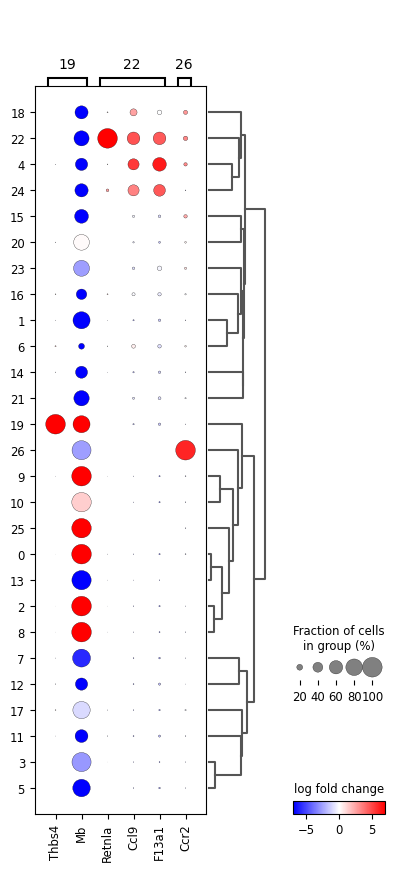

In [43]:
sc.pl.rank_genes_groups_dotplot(
    ad_spatial_common,
    n_genes=30,
    values_to_plot="logfoldchanges",
    min_logfoldchange=4,
    vmax=7,
    vmin=-7,
    cmap="bwr",
    groups=["19","22","26"],
)

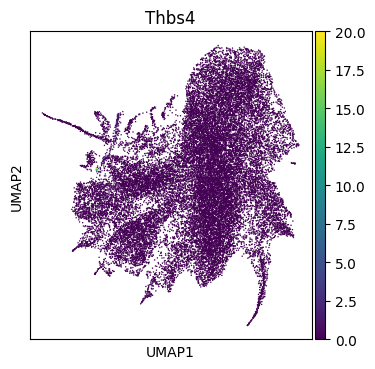

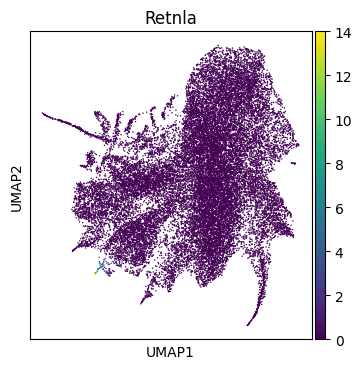

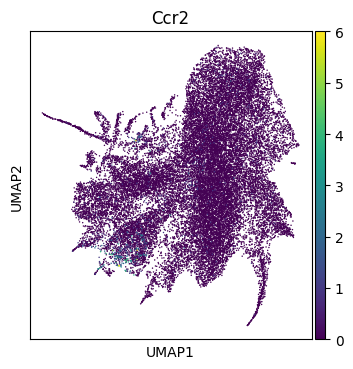

In [44]:
sc.pl.umap(ad_spatial_common, color="Thbs4")
sc.pl.umap(ad_spatial_common, color="Retnla")
sc.pl.umap(ad_spatial_common, color="Ccr2")

In [45]:
# Save the Leiden clusters for all resolution parameters as well as normalized count data in h5ad format. 
ad_spatial_common.write_h5ad(spdatapath+'sct_spatial.h5ad')

In [46]:
df=pd.read_csv(scdatapath+'anno_simple_new.csv')
#df
df[ df['cluster_ann_simplify']=='CM_Dedifferentiating']

,Unnamed: 0,cells_timepoints,cluster_ann_simplify
77791,CM1Ad_MI_D01_TGGAGGAGTGCGCTCA-1,D01,CM_Dedifferentiating
80243,CM2Ad_MI_D01_CTGTATTCATGACGAG-1,D01,CM_Dedifferentiating
80259,CM2Ad_MI_D01_GAGTTGTGTGTGGACA-1,D01,CM_Dedifferentiating
80327,CM2Ad_MI_D01_TCAGTCCTCCAGTGTA-1,D01,CM_Dedifferentiating
80337,CM2Ad_MI_D01_TCCTTTCTCAGCTGTA-1,D01,CM_Dedifferentiating
80392,CM2Ad_MI_D03_AAGTGAAGTAGAGACC-1,D03,CM_Dedifferentiating
80449,CM2Ad_MI_D03_GGTAGAGCAGAGTGTG-1,D03,CM_Dedifferentiating
80500,CM2Ad_MI_D07_ACTATCTAGACCCTTA-1,D07,CM_Dedifferentiating
80546,CM2Ad_MI_D07_GAGACTTGTTAAACAG-1,D07,CM_Dedifferentiating
80547,CM2Ad_MI_D07_GATAGCTTCTAGCATG-1,D07,CM_Dedifferentiating


In [47]:
print(ad_spatial_common.var_names)

Index(['0610005C13Rik', '1110017D15Rik', '2610528A11Rik', '5330417C22Rik',
       '5830411N06Rik', '6330403K07Rik', 'A330076H08Rik', 'AU021092', 'Aadat',
       'Abca13',
       ...
       'Vsnl1', 'Vsx2', 'Vwf', 'Wif1', 'Wnt3', 'Wnt5a', 'Xcl1', 'Xcr1',
       'Xirp2', 'Zbtb46'],
      dtype='object', length=468)


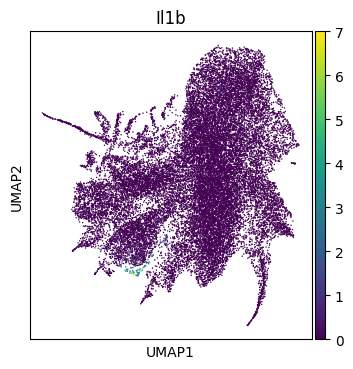

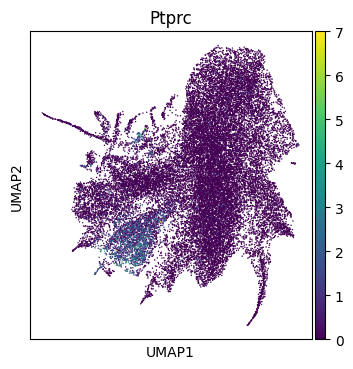

In [48]:
sc.pl.umap(ad_spatial_common, color="Il1b")
sc.pl.umap(ad_spatial_common, color="Ptprc")

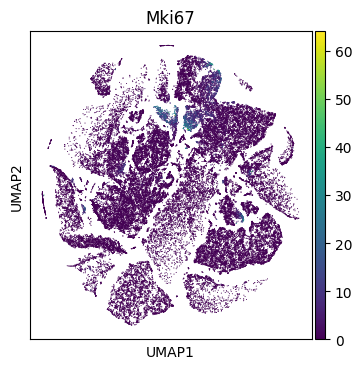

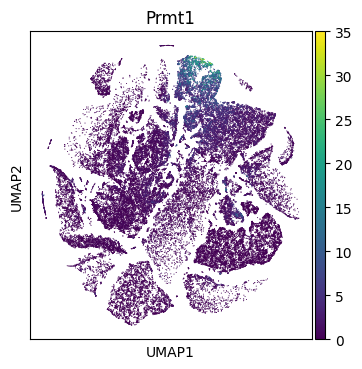

In [49]:
sc.pl.umap(ad_seq_ori, color="Mki67")
sc.pl.umap(ad_seq_ori, color="Prmt1")

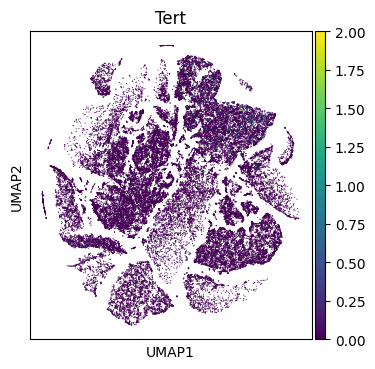

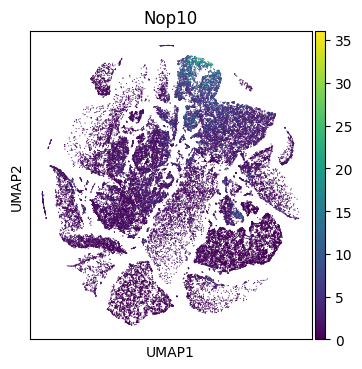

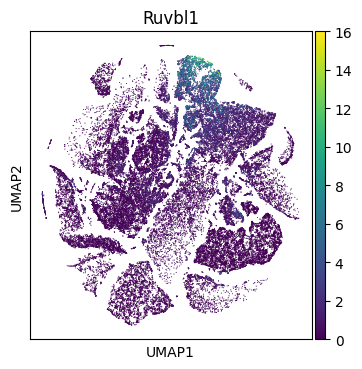

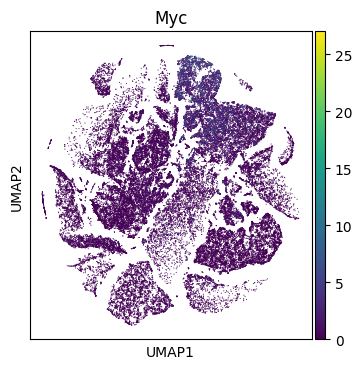

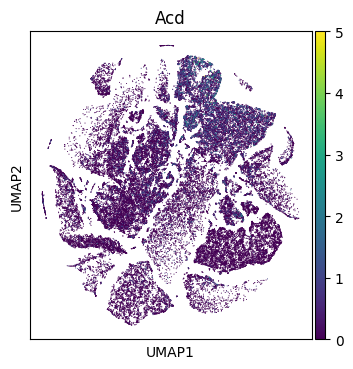

In [50]:
sc.pl.umap(ad_seq_ori, color="Tert")
sc.pl.umap(ad_seq_ori, color="Nop10")
sc.pl.umap(ad_seq_ori, color="Ruvbl1")
sc.pl.umap(ad_seq_ori, color="Myc")
sc.pl.umap(ad_seq_ori, color="Acd")

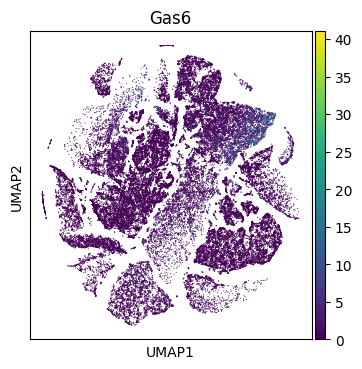

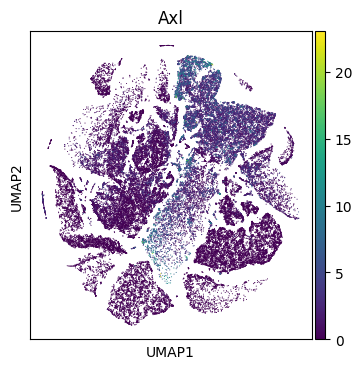

In [51]:
sc.pl.umap(ad_seq_ori, color="Gas6")
sc.pl.umap(ad_seq_ori, color="Axl")

In [52]:
ad_spatial_common.shape

(27452, 468)

In [53]:
np.unique(ad_seq_common.obs['detail_annot'])

array(['B_cells', 'CM_Angiogenic', 'CM_Btk+', 'CM_Dedifferentiating',
       'CM_Homeostatic1', 'CM_Homeostatic2', 'CM_Hypertrophic',
       'CM_Prehypertrophic', 'CM_Slit2+', 'DC_CCR7', 'DC_con1',
       'DC_con2_Ifitm1', 'DC_con2b/moDC', 'DC_plasmacytoid',
       'Erythrocyte', 'FB_Duox1', 'FB_Fgl2', 'FB_Postn_Thbs4', 'FB_Saa3',
       'FB_WntX', 'FB_quiescent', 'FB_transition_Cd9',
       'FB_transition_Il1rapl1', 'FBmyo_IFN', 'FBmyo_main', 'Fbmyo_Hp',
       'Fbmyo_cycling', 'Fibrocytes', 'ILC2', 'ILC2_IL5', 'MAIT',
       'MAIT_IL17', 'Macro_Cxcl13', 'Macro_MHCII_Cx3cr1', 'Macro_Retnla',
       'Macro_Timd4_Lyve1', 'Macro_Trem2_Gpnmb', 'Mast_cells', 'NK_Gzma',
       'NK_Klra5', 'NK_T', 'Neutrophil_1', 'Neutrophil_2',
       'Schwann_Galectin', 'Schwann_IFN', 'Schwann_metabolic',
       'Schwann_quiescent', 'T_CD4', 'T_CD8', 'T_IFNg_naive', 'T_Isg15',
       'T_Macro', 'T_gd', 'Treg', 'mo_Macro_Il10_Fn1',
       'mo_Macro_Ly6C_Isg15_Cxcl3', 'mo_Macro_Spp1', 'vEC_Areg_Dkk2_Wnt',
  

In [54]:
np.sum(ad_seq_common.obs['detail_annot']=='CM_Dedifferentiating')

11

In [55]:
np.sum(ad_seq_common.obs['simple_annot']=='CM_Dedifferentiating')

11

KeyError: ''

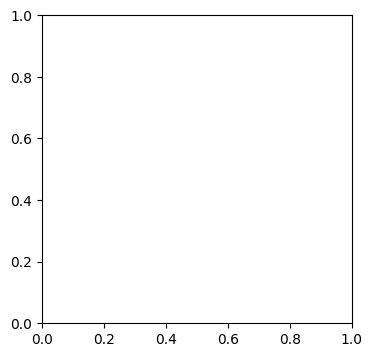

In [56]:
sc.pl.umap(ad_seq_common,color=[''])

In [ ]:
# define the scorring of genes of interest (dedifferentiating CM genes in spatial genelist)
sc.tl.score_genes(ad_spatial_common, ["Mb", "Des","Myl9","Nkx2-5","Cox8b","Il1b"])

In [ ]:
ad_spatial_common.obs['score']

In [ ]:
sc.pl.umap(ad_spatial_common, color="score")

In [ ]:
sc.pl.spatial(ad_spatial_common, basis = 'spatial', color = 'score', spot_size = 40)